In [24]:
#model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization

#keras tuner
from keras_tuner import RandomSearch
import keras
import keras_tuner as kt

#data
from send_to_racing import bbox,depth_values;

#baics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow_model_optimization as tfmot
import math

#pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch


In [25]:
#DATA SET
X = np.array(bbox)
Y = np.array(depth_values)
df = pd.DataFrame(X , columns= ['class' , 'x ', 'y','w','h', 'confidence'])
df['ratio']  = df['h']/df['w']
#print(df['ratio'])
df = df[['y' , 'w' , 'h' , 'confidence' , 'class' , 'ratio']]#including class here becasue of the mention in ADR(THINK LATER) -will check during feature engineering
X = np.asarray(df).astype('float32')
X = torch.from_numpy(X)
print(X.shape)

torch.Size([441, 6])


In [61]:
X_train, X_test, Y_train, Y_test  = train_test_split(X,Y,test_size=0.1, shuffle=True)#X_test for final check .mostly validation will only be used for the model
X_train, X_val, Y_train, Y_val  = train_test_split(X_train,Y_train,test_size=0.4, shuffle=True)#X_test for final check .mostly validation will only be used for the model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)



In [35]:
def build_model(hp):
    model = Sequential()

    #LAYER1
    hp_layer1 = hp.Int('layer1',min_value = 2,max_value=12 , step = 2)
    model.add(Dense(units = hp_layer1))
    #relu or leakyrelu(need to be added separately)
    activation1 = hp.Choice('activation1', ['relu', 'leakyrelu'])
    if activation1 == 'relu':
        model.add(tf.keras.layers.Activation('relu'))
    else:
        model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))#prevent overdependence
    model.add(BatchNormalization())

    '''
    #WOURLD TEST THE ACCURACY SEPARATELY FOR 2 LAYERS BY UNCOMMENTING THISBUT CURRENTLY THIS SEEMS BETTER
    #SECOND LAYER
    hp_layer2 = hp.Int('layer2',min_value = 2,max_value=12 , step = 2)
    model.add(Dense(units = hp_layer2),input_dim = X_train.shape[1])
    activation1 = hp.Choice('activation1', ['relu', 'leakyrelu'])
    if activation1 == 'relu':
        model.add(tf.keras.layers.Activation('relu'))
    else:
        model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))#prevent overdependence
    '''

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Learning rate
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3 ,1e-2 ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mse'])
    
    return model


    

In [36]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=20,  # Number of models to try
    executions_per_trial=3,  # Number of times to train each model
    directory='my_dir',
    project_name='keras_tuning'
)



Reloading Tuner from my_dir/keras_tuning/tuner0.json


In [37]:

tuner.search(X_train, Y_train,
             epochs=100,  # Max epochs, you can use EarlyStopping to stop earlier
             validation_data=(X_val, Y_val),
             batch_size=32)

Trial 20 Complete [00h 00m 11s]
val_mse: 0.18006748457749686

Best val_mse So Far: 0.07459662606318791
Total elapsed time: 00h 10m 06s


In [66]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
 
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train,
                    epochs=100,
                    validation_data=(X_val, Y_val),

                    )#NOT HAVING callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)] SINCE IT LEADS TO DRASTIC DROP IN ACCURACY( DOES NOT REALLY MAKE SENSE BUT KINDA LIKE A MANUAL OBSERVATION)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 28.5657 - mse: 28.5657 - val_loss: 18.4841 - val_mse: 18.4841
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.5705 - mse: 24.5705 - val_loss: 13.9211 - val_mse: 13.9211
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1936 - mse: 17.1936 - val_loss: 9.9158 - val_mse: 9.9158
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.0401 - mse: 14.0401 - val_loss: 6.4253 - val_mse: 6.4253
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8959 - mse: 9.8959 - val_loss: 3.5439 - val_mse: 3.5439
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1351 - mse: 5.1351 - val_loss: 1.7478 - val_mse: 1.7478
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9482 - mse: 2.9482 - val_loss: 1.0896 - val_mse: 1.0896
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5479 - mse: 1.5479 - val_loss: 1.0840 - val_mse: 1.0840
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3198 - ms

In [70]:
print("best hyperparamter values:")
print(f"units1 {best_hps.get('layer1')}")
print(f"learning rate {best_hps.get('learning_rate')}")
print(f"dropout {best_hps.get('dropout1')}")
print(f"actiavtion {best_hps.get('activation1')}")


best hyperparamter values:
units1 10
learning rate 0.01
dropout 0.1
actiavtion leakyrelu


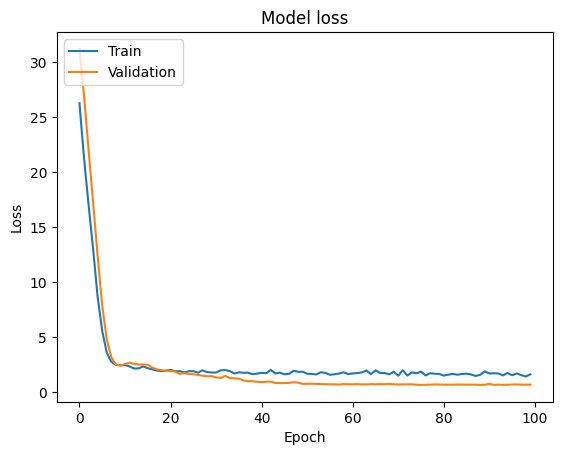

In [57]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [73]:
start_time = time.time()
predictions= model.predict(X_test)
end_time = time.time()


print(f"average time taken{(end_time-start_time)/len(X_test)}")
mse = model.evaluate(X_test, Y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
average time taken0.0006552908155653212
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2661 - mse: 0.2661
